# Technical setup
> Skip this section

In [54]:
# @formatter:off

In [55]:
%%time
%reload_ext autoreload
%autoreload 2
# @formatter:on

CPU times: user 4.31 ms, sys: 6.43 ms, total: 10.7 ms
Wall time: 11.2 ms


# Parameters

In [56]:
symbol = 'ETHUSDT'
symbol_k_lines_interval = '1s'
symbol_ask_bid_price_difference = 0.01

# Ticks

/Users/nikita/Documents/projects/things-team/to-the-moon/ttm-analytics/src/chart/ttm_chart.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator


,timestamp,bid_price,ask_price
0,1677628800000,1605.24,1605.25
1,1677628801000,1605.46,1605.47
2,1677628802000,1605.46,1605.47
3,1677628803000,1605.46,1605.47
4,1677628804000,1605.47,1605.48
...,...,...,...
86395,1681775995000,2074.00,2074.01
86396,1681775996000,2074.00,2074.01
86397,1681775997000,2074.00,2074.01
86398,1681775998000,2074.00,2074.01


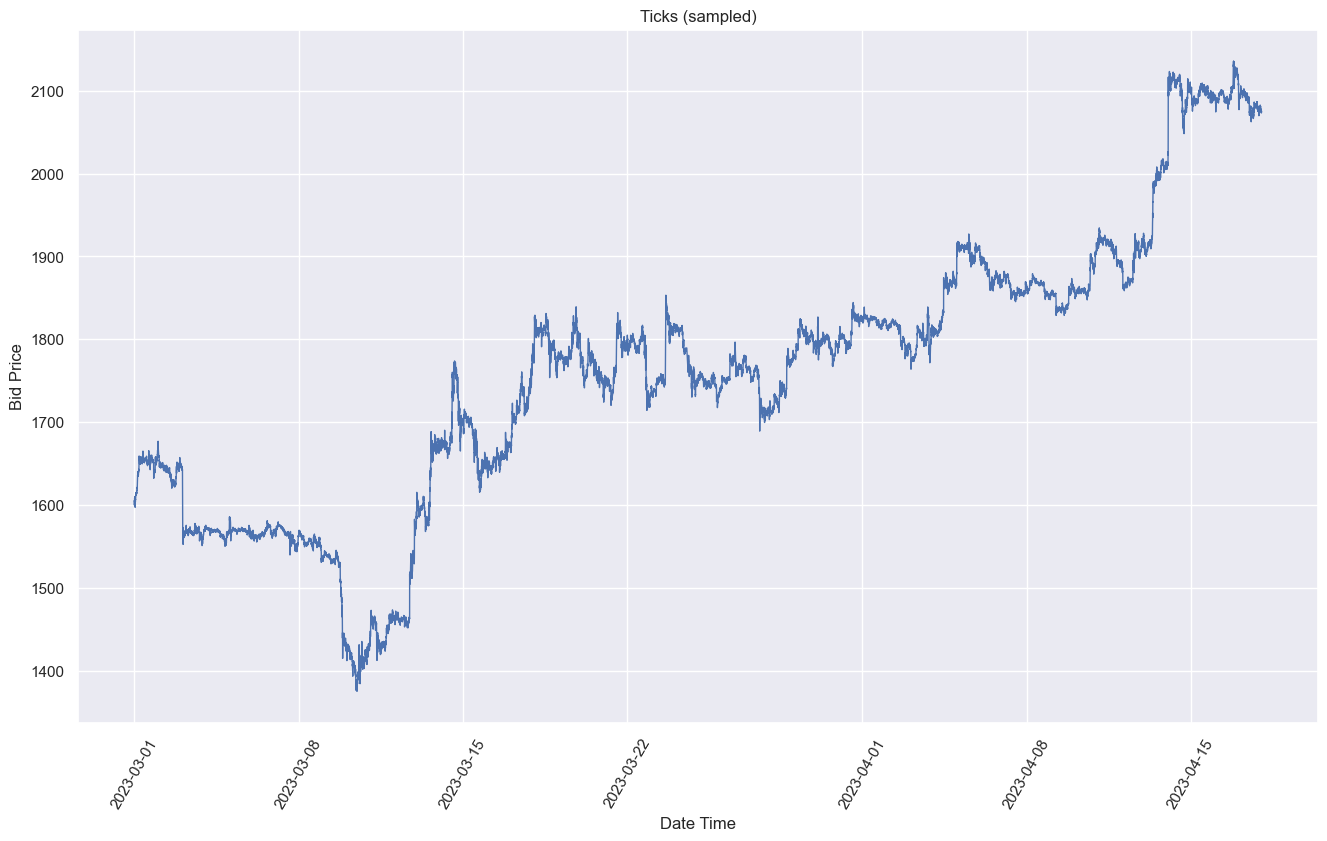

In [57]:
from IPython.core.display_functions import display

from binance.binance_k_line_loader import load_binance_k_lines
from binance.binance_tick_loader import load_binance_ticks
from chart.ttm_chart import draw_line_chart

k_lines = load_binance_k_lines(f"../../../ttm-data/{symbol}-{symbol_k_lines_interval}-*.csv")

ticks = load_binance_ticks(k_lines, symbol_ask_bid_price_difference)

draw_line_chart(ticks, 'timestamp', 'bid_price', 'Bid Price', 'Ticks')

display(ticks)

# Simulation Setup

In [58]:
# @formatter:off

In [59]:
%%time
# @formatter:on

from trade.trade_simulator import TradeSimulator

trade_simulator: TradeSimulator = TradeSimulator(ticks)

CPU times: user 51.6 s, sys: 743 ms, total: 52.3 s
Wall time: 52.5 s


# Simulation

/Users/nikita/Documents/projects/things-team/to-the-moon/ttm-analytics/src/chart/ttm_chart.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator


'orders: 30,049, avg price change: 0.06, tx avg price margin: 1.99, tx avg prof: -0.04, tx cum prof: -1199.56'

/Users/nikita/Documents/projects/things-team/to-the-moon/ttm-analytics/src/chart/ttm_chart.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator


'orders: 5,753, avg price change: 0.06, tx avg price margin: 4.63, tx avg prof: -0.01, tx cum prof: -36.66'

/Users/nikita/Documents/projects/things-team/to-the-moon/ttm-analytics/src/chart/ttm_chart.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator


'orders: 1,543, avg price change: 0.06, tx avg price margin: 9.01, tx avg prof: 0.01, tx cum prof: 14.95'

/Users/nikita/Documents/projects/things-team/to-the-moon/ttm-analytics/src/chart/ttm_chart.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator


'orders: 683, avg price change: 0.06, tx avg price margin: 13.33, tx avg prof: 0.03, tx cum prof: 19.44'

/Users/nikita/Documents/projects/things-team/to-the-moon/ttm-analytics/src/chart/ttm_chart.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator


'orders: 380, avg price change: 0.06, tx avg price margin: 17.68, tx avg prof: -0.68, tx cum prof: -258.47'

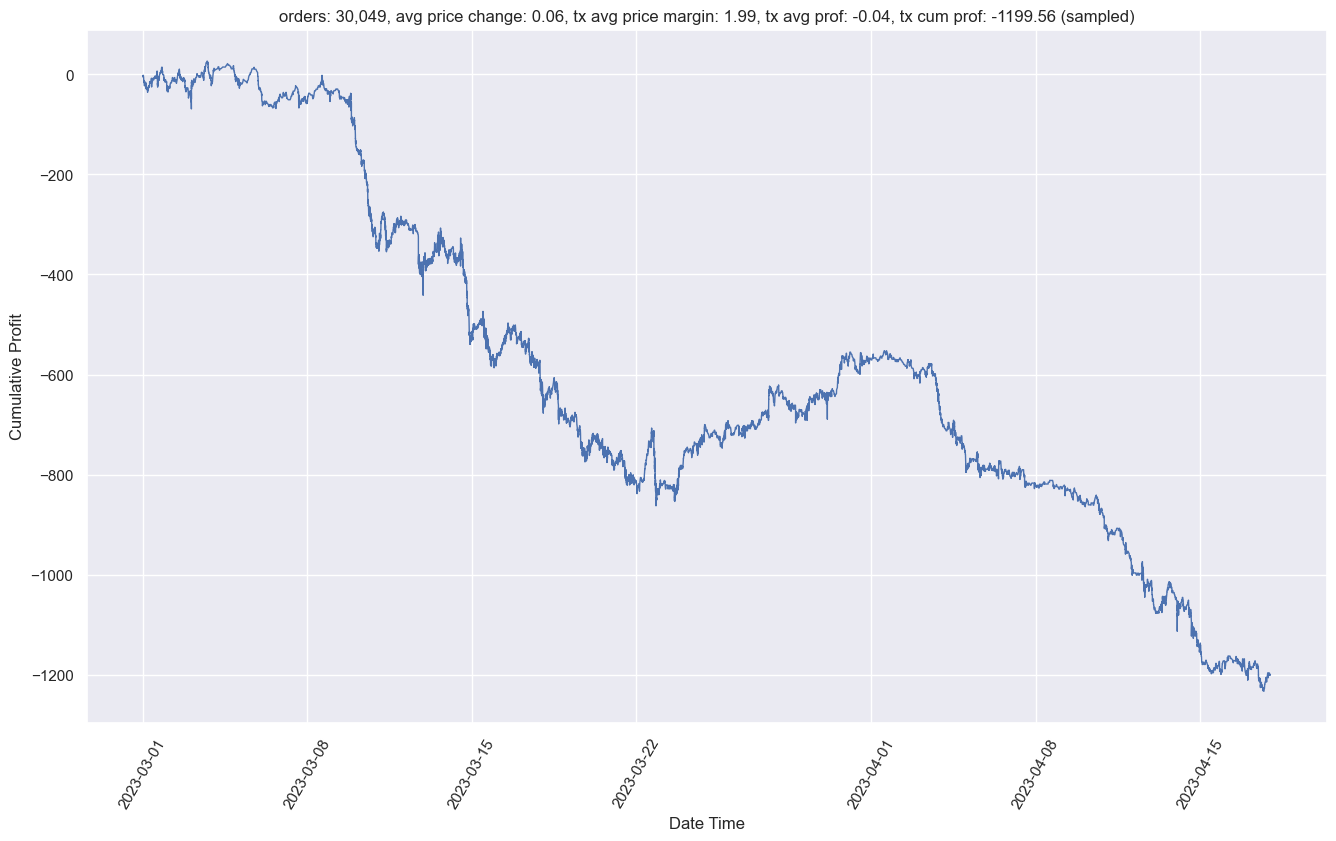

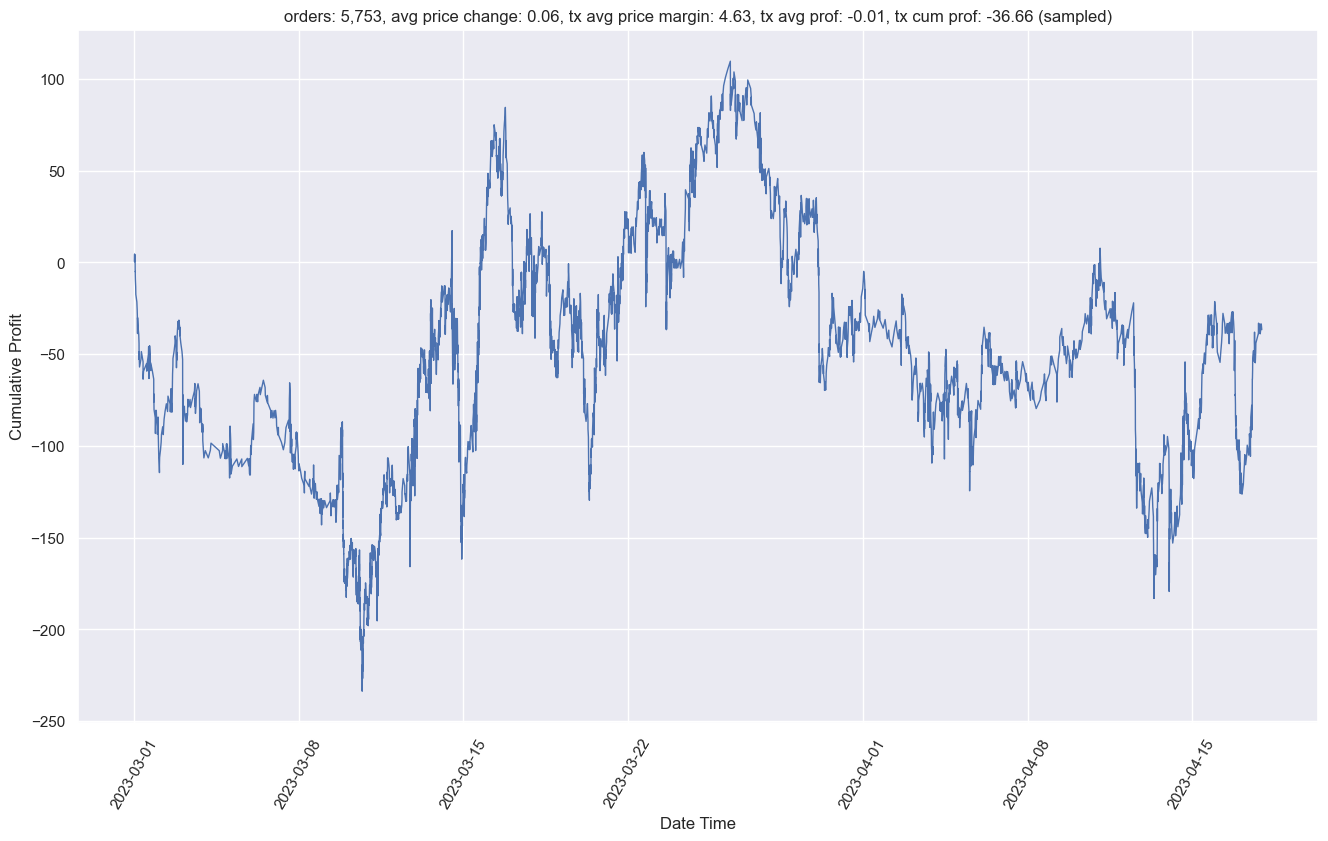

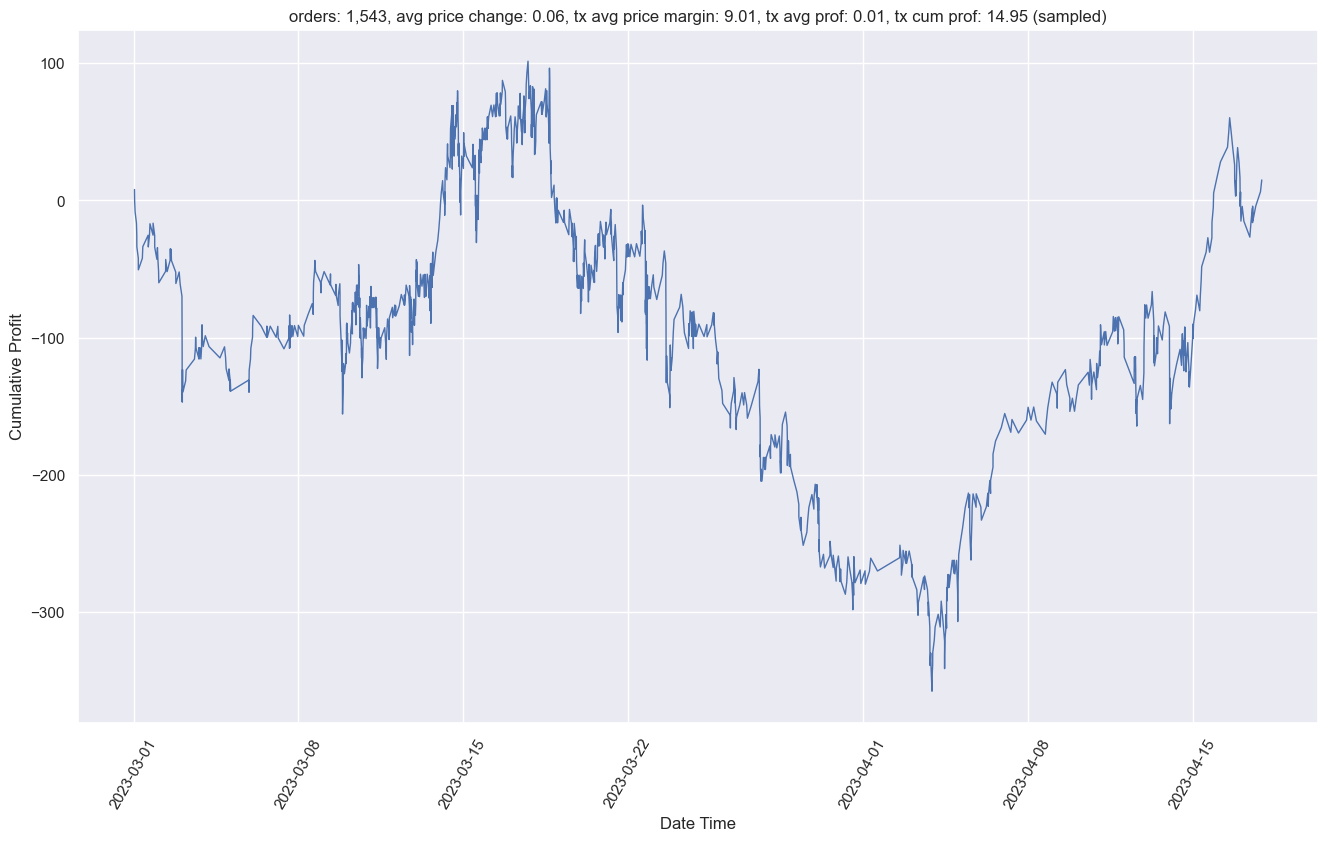

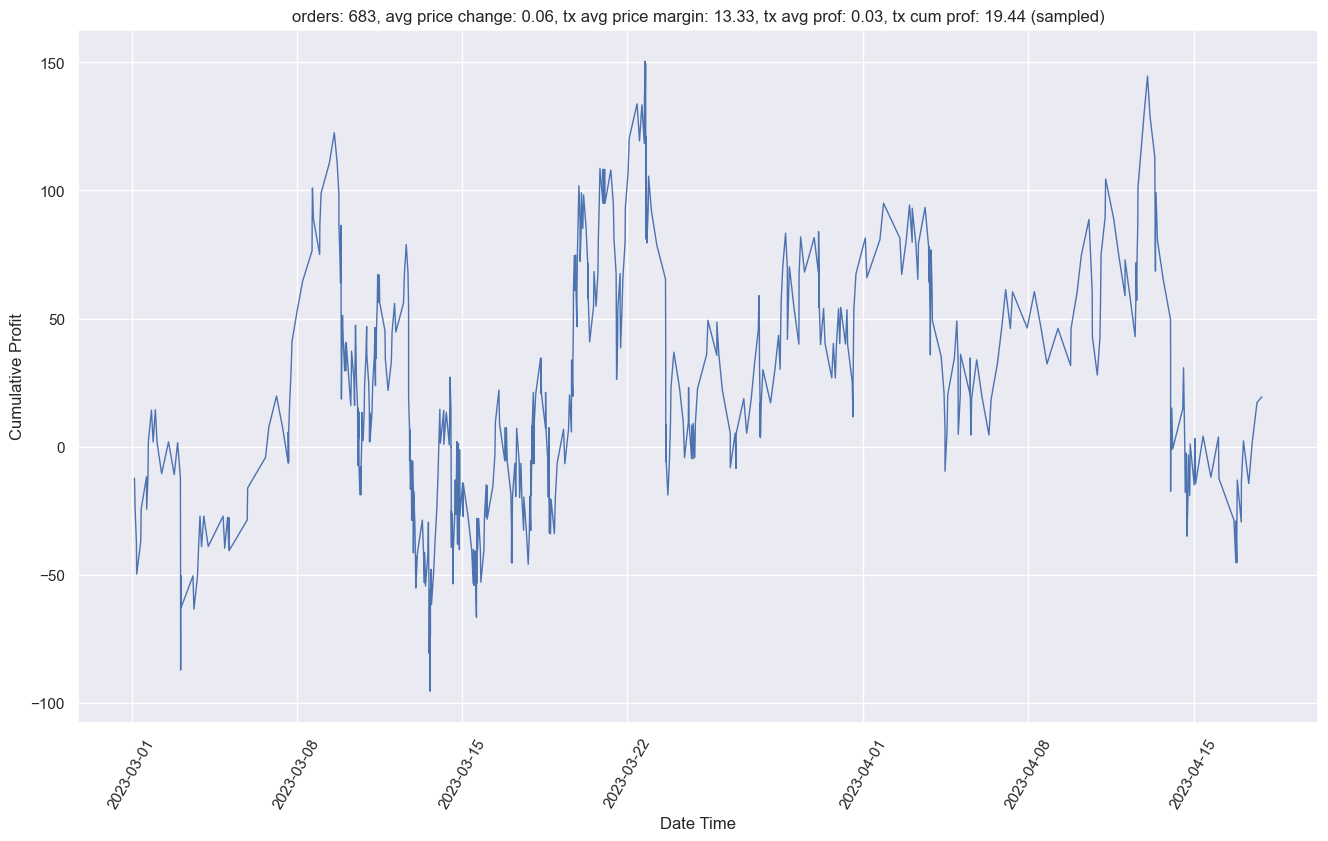

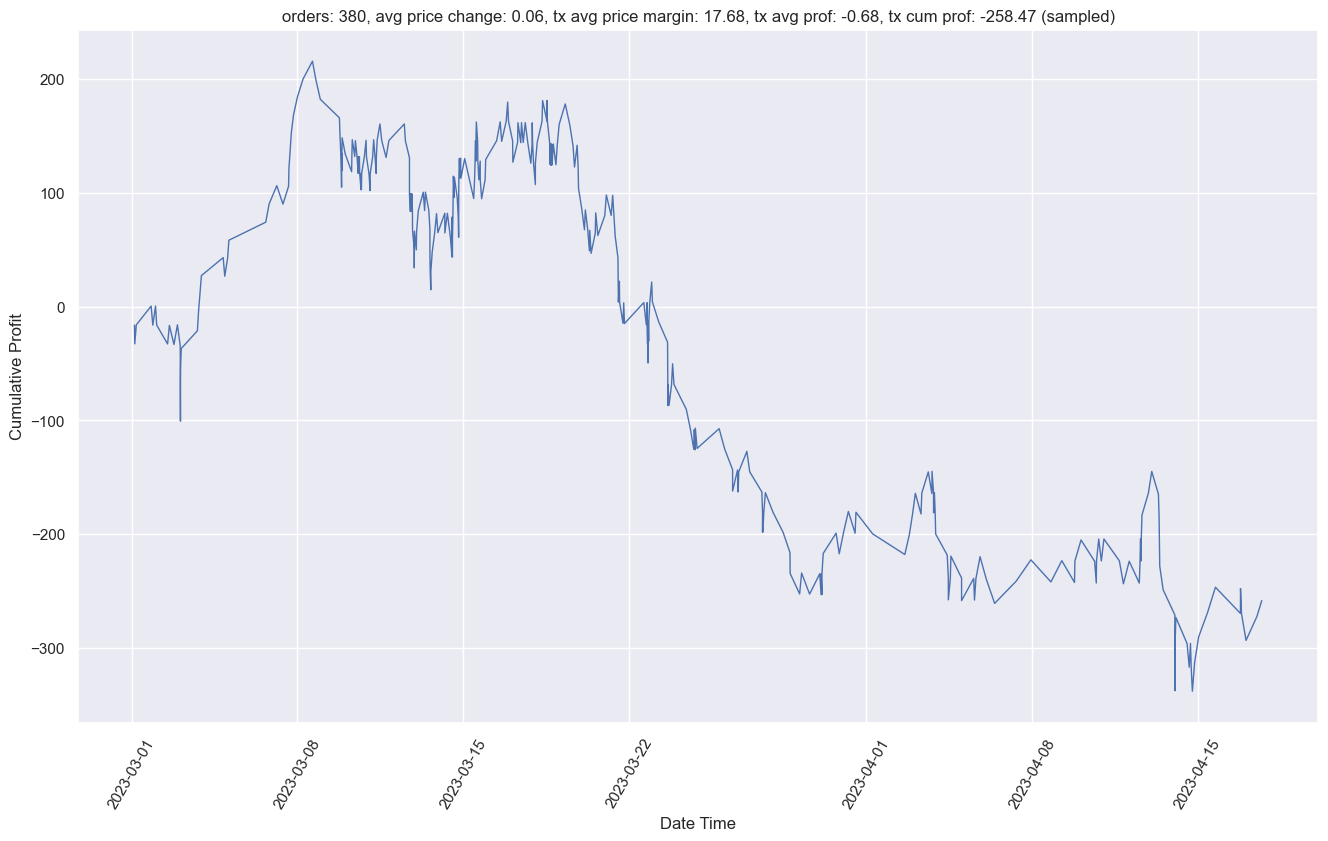

In [61]:
from analytics.bot_strategy_0 import BotStrategy0

for price_step_ratio in [0.001, 0.0025, 0.005, 0.0075, 0.01]:
    transactions = trade_simulator.simulate(BotStrategy0(price_step_ratio))
    # 'orders: 30,049, avg. price margin: 1.99, avg. profit: -0.04, cum. profit: -1199.56'
    result_str = (f"orders: {len(transactions.index):,}"
                  f", avg tick price change: {ticks.ask_price.diff().abs().mean():.2f}"
                  f", tx avg price margin: {transactions.price_margin.mean():.2f}"
                  f", tx avg prof: {transactions.profit.mean():.2f}"
                  f", tx cum prof: {transactions.cumulative_profit.iloc[-1]:.2f}")
    draw_line_chart(transactions, 'open_timestamp', 'cumulative_profit', 'Cumulative Profit', result_str)
    display(result_str)
    # display(transactions)

